In [2]:
import matplotlib.pyplot as plt
import wfdb
import numpy as np

In [3]:
from utils import *

In [5]:
data_dir = "data/mit-bih-arrhythmia-database-1.0.0/"
record_name = "117"

rec = read_record(f"{data_dir}{record_name}")

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\sebas\\one\\OneDrive\\grive\\faks\\masters\\y1\\Biomedical Signal and Image Processing\\biomed-signal-processing\\qrs_detection\\data\\mit-bih-arrhythmia-database-1.0.0\\117.hea'

In [4]:
sig = rec.p_signal
ann = read_annotation(f"{data_dir}{record_name}")

# sig = sig - sig.mean()  # Normalize

High pass filter to remove noise

In [5]:
from scipy.signal import butter, lfilter

def apply_high_pass_filter(signal, cutoff_freq, fs, order=4):
    """
    Applies a high-pass Butterworth filter to the signal.
    
    Parameters:
    - signal: Input ECG signal (1D array).
    - cutoff_freq: Cutoff frequency of the filter in Hz.
    - fs: Sampling frequency of the signal in Hz.
    - order: Order of the Butterworth filter (default is 4).
    
    Returns:
    - filtered_signal: Signal after high-pass filtering.
    """
    # Normalize the cutoff frequency to the Nyquist frequency
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff_freq / nyquist

    # Design the Butterworth high-pass filter
    b, a = butter(order, normalized_cutoff, btype='high', analog=False)

    filtered_signal = lfilter(b, a, signal)
    filtered_signal = lfilter(b, a, filtered_signal[::-1])[::-1]

    return filtered_signal


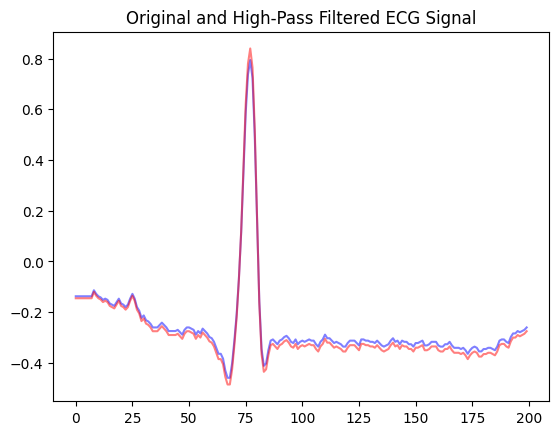

In [6]:

orig_sig = sig.copy()   
sig = apply_high_pass_filter(sig, 1.6, rec.fs, order=3)
# sig = apply_high_pass_filter(sig[::-1], 1.6, rec.fs, order=3)

# Plot the signal
plt.plot(sig[:200, 0], alpha=0.5, c="b")
plt.plot(orig_sig[:200, 0], alpha=0.5, c="r")
plt.title("Original and High-Pass Filtered ECG Signal")
# Plot the annotations
plt.show()

In [7]:
sample_len = len(sig)

fs = rec.fs  # Sampling frequency
signal = sig[:sample_len, 0]  # Example signal

# Step 1: Apply the Haar-like matched filter
fil = create_haar_like_filter(fs)
delay_smp, delay_time = calculate_convolution_delay(fil, fs)

print("Signal delayed by", delay_smp, "samples.")

filtered_signal = apply_matched_filter(signal, fs)
# filtered_signal = filtered_signal / np.max(filtered_signal)                 # Normalize the filtered signal
filtered_signal = [0 for i in range(delay_smp)] + list(filtered_signal)     # Add delay to the filtered signal
filtered_signal = filtered_signal[:sample_len]                                    # Truncate the filtered signal
filtered_signal = np.array(filtered_signal)

# Step 2: Calculate the second-order difference
second_diff = second_order_difference(signal)

# Step 3: Calculate the score function
score = calculate_score(second_diff, filtered_signal, second_diff)

# Step 4: Sift R-wave candidates
# r_wave_candidates = sift_r_wave_candidates(score, fs, threshold=np.max(score)/150)
r_wave_candidates = sift_r_wave_candidates_dynamic(score, fs, percentile=80, min_value=np.max(score)/50)

# Output results
print("Filtered Signal:", filtered_signal)
print("Second-Order Difference:", second_diff)
print("Score Function:", score)
print("R-wave Peak Candidates (indices):", r_wave_candidates)
print(max(score))


Signal delayed by 21 samples.
Filtered Signal: [0.         0.         0.         ... 9.05313203 6.09216208 2.10712158]
Second-Order Difference: [ 0.          0.          0.         ... -0.13239503  0.40191347
  0.        ]
Score Function: [ 0.          0.          0.         ... -1.85781395  3.79520911
  0.        ]
R-wave Peak Candidates (indices): [78, 372, 664, 948, 1232, 1516, 1811, 2046, 2404, 2707, 3002, 3287, 3561, 3864, 4171, 4467, 4766, 5061, 5351, 5634, 5920, 6216, 6528, 6825, 7107, 7394, 7671, 7954, 8247, 8541, 8839, 9142, 9434, 9712, 9999, 10284, 10592, 10896, 11193, 11481, 11783, 12070, 12352, 12646, 12951, 13267, 13563, 13843, 14135, 14424, 14715, 15013, 15311, 15608, 15901, 16184, 16466, 16757, 17059, 17360, 17658, 17948, 18229, 18515, 18797, 19082, 19390, 19695, 19994, 20273, 20559, 20839, 21133, 21425, 21730, 22031, 22322, 22604, 22882, 23168, 23455, 23758, 24055, 24347, 24627, 24916, 25202, 25487, 25781, 26090, 26388, 26672, 26954, 27239, 27541, 27833, 28134, 28432, 2

In [8]:
len(r_wave_candidates), np.max(score)/10

(2280, 0.4949242311402437)

Adaptive Threshold: 0.00024787413555312496


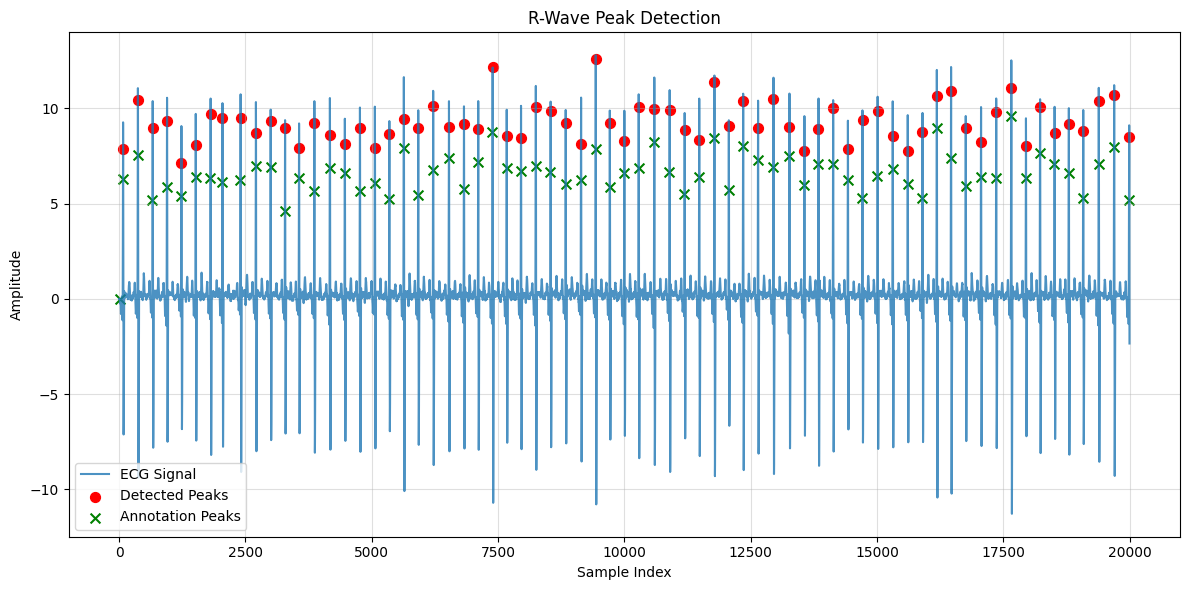

2280

In [9]:
# Compute the adaptive threshold and refine candidates
refined_r_wave_candidates = refine_r_wave_candidates(
    score, r_wave_candidates, fs, 
    lambda score, peaks, fs: calculate_adaptive_threshold(score, peaks, fs, T=.01, beta1=1e-5, beta2=1e-5)
)
lim = 20_000
plot_detected_peaks(filtered_signal[:lim], refined_r_wave_candidates, fs, ann.sample[:len(refined_r_wave_candidates)])
len(refined_r_wave_candidates)

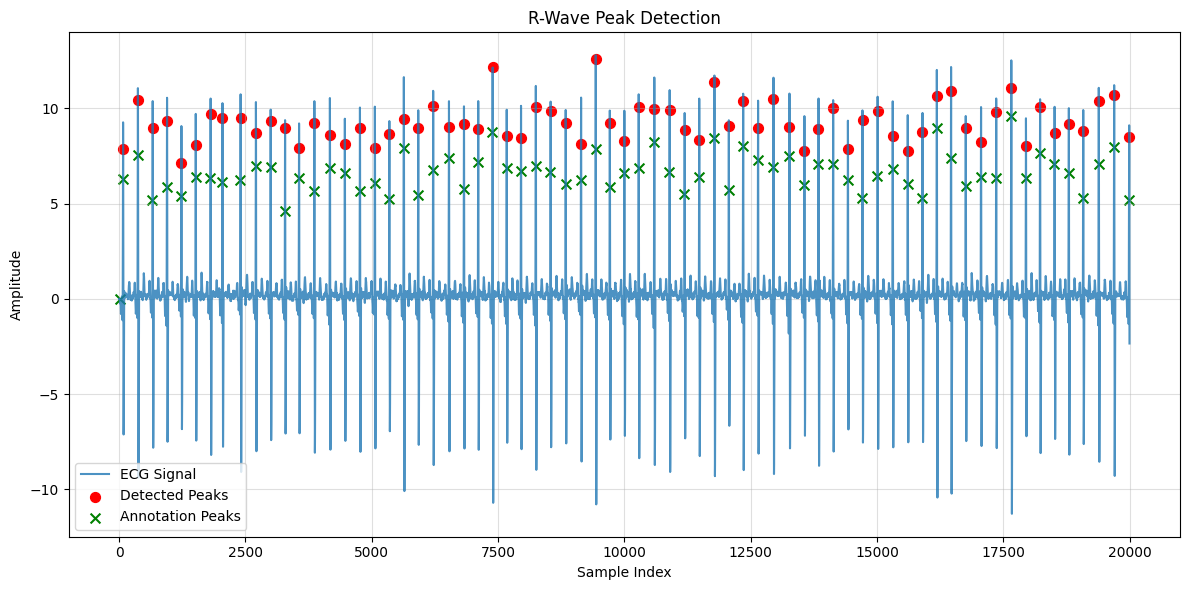

In [10]:
plot_detected_peaks(filtered_signal[:lim], r_wave_candidates, fs, ann.sample[:len(refined_r_wave_candidates)])


[78, 372, 664, 948, 1232, 1516, 1811, 2046, 2404, 2707, 3002, 3287, 3561, 3864, 4171, 4467, 4766, 5061, 5351, 5634, 5920, 6216, 6528, 6825, 7107, 7394, 7671, 7954, 8247, 8541, 8839, 9142, 9434, 9712, 9999, 10284, 10592, 10896, 11193, 11481, 11783, 12070, 12352, 12646, 12951, 13267, 13563, 13843, 14135, 14424, 14715, 15013, 15311, 15608, 15901, 16184, 16466, 16757, 17059, 17360, 17658, 17948, 18229, 18515, 18797, 19082, 19390, 19695, 19994, 20273, 20559, 20839, 21133, 21425, 21730, 22031, 22322, 22604, 22882, 23168, 23455, 23758, 24055, 24347, 24627, 24916, 25202, 25487, 25781, 26090, 26388, 26672, 26954, 27239, 27541, 27833, 28134, 28432, 28728, 29016, 29298, 29582, 29873, 30183, 30489, 30784, 31066, 31350, 31637, 31929, 32226, 32532, 32838, 33129, 33408, 33693, 33985, 34275, 34576, 34872, 35169, 35456, 35741, 36018, 36312, 36606, 36921, 37220, 37501, 37784, 38072, 38361, 38653, 38955, 39254, 39549, 39827, 40097, 40384, 40679, 40971, 41273, 41571, 41850, 42118, 42418, 42698, 42998, 433

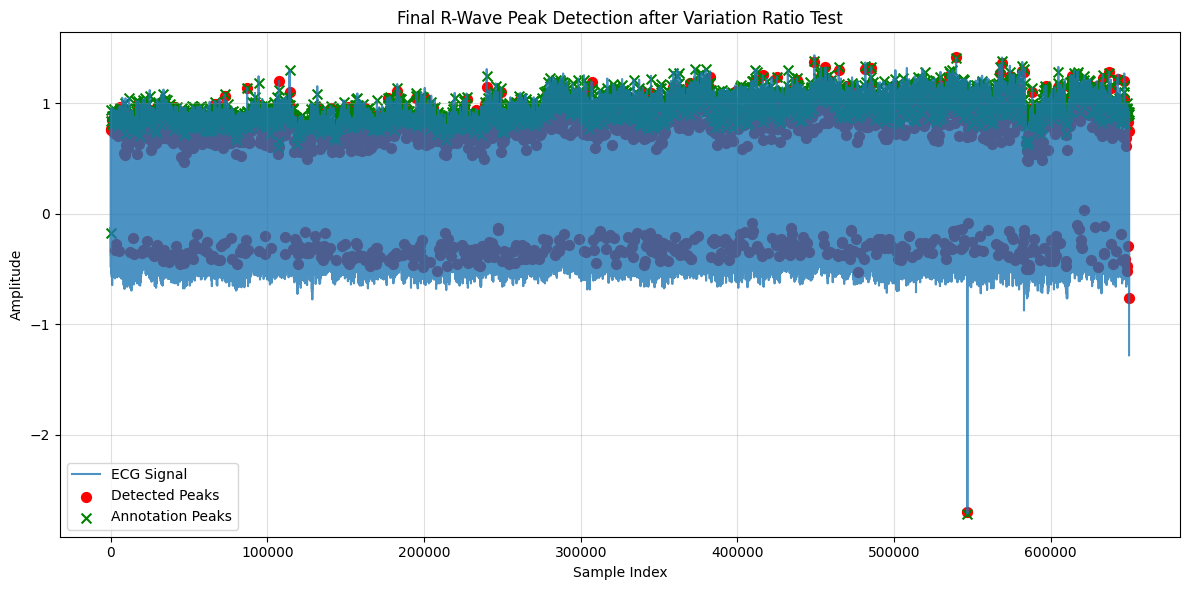

In [11]:

# Perform Variation Ratio Test
refined_peaks_variation_test = variation_ratio_test(
    signal=signal, 
    peak_candidates=refined_r_wave_candidates, 
    fs=fs, 
    window=0.2,
    threshold=0.2
)


print(refined_peaks_variation_test)

# Plot the final detected peaks
plot_detected_peaks(
    signal=orig_sig[:,0], 
    peak_indices=refined_peaks_variation_test,
    fs=fs, 
    ann=ann.sample[:len(refined_peaks_variation_test)+1], 
    title="Final R-Wave Peak Detection after Variation Ratio Test"
)


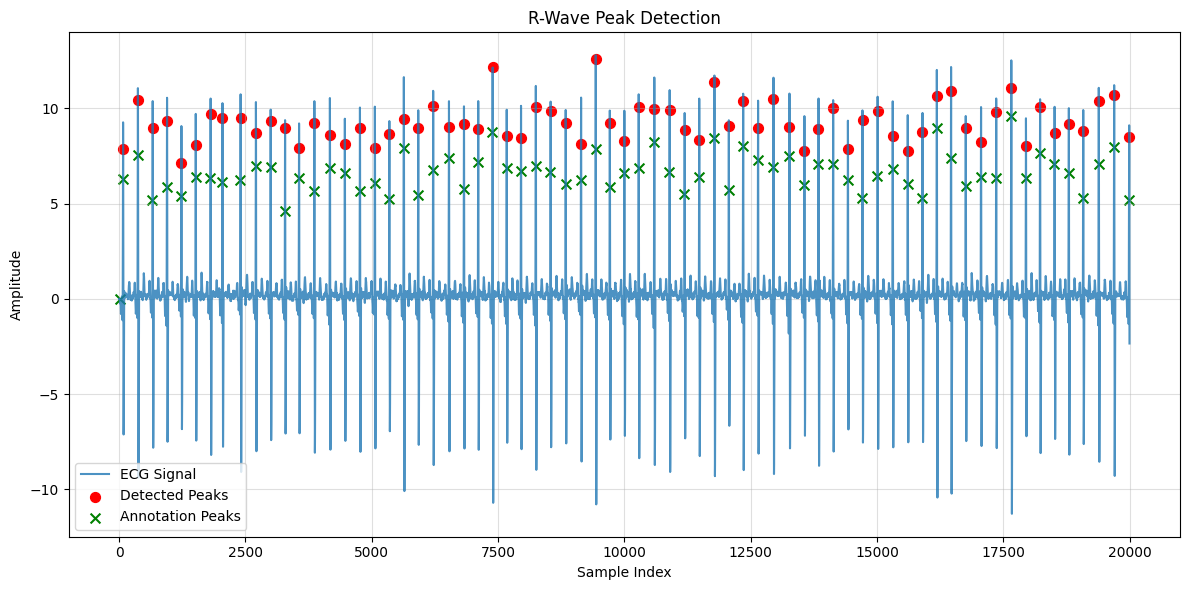

In [12]:
plot_detected_peaks(filtered_signal[:lim], refined_peaks_variation_test, fs, ann.sample[:len(refined_r_wave_candidates)])

In [13]:
[i for i in ann.sample if i > 15000 and i < 17500]

[15011, 15310, 15607, 15899, 16183, 16464, 16755, 17058, 17358]

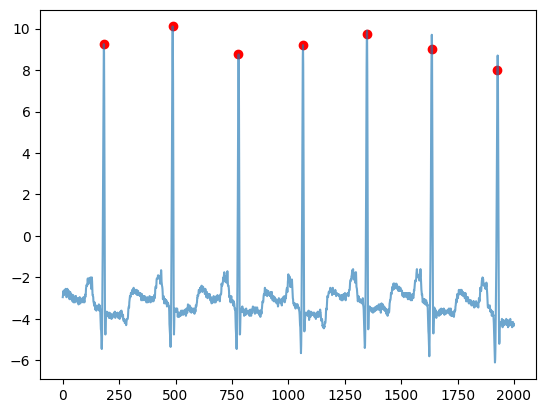

In [14]:
start, stop = 30000, 32000

# plt.plot(filtered_signal[start:stop], alpha=.65)
plt.scatter([i-start for i in ann.sample if i > start and i < stop], [orig_sig[i, 0]*10 for i in ann.sample if i > start and i < stop], c="r")
# plt.scatter([i-start for i in ann.sample if i > start and i < stop], [filtered_signal[i] for i in ann.sample if i > start and i < stop], c="r")

plt.plot(orig_sig[start:stop, 0]*10, alpha=.65)
# plt.plot(filtered_signal[start:stop], alpha=.65)



In [15]:
len(ann.sample), len(sig[ann.sample]), sig[ann.sample] 

(2274,
 2274,
 array([[-0.16076539, -0.02932685],
        [ 0.79437015,  0.10986342],
        [ 0.88893803,  0.24115224],
        ...,
        [ 0.84165409,  0.34573001],
        [ 0.85111088, -0.15180764],
        [ 0.87002445,  0.21489448]]))

In [16]:
def sensitivity(tp, fn):
    """
    Calculate the Sensitivity (SE) metric.
    
    SE = TP / (TP + FN)
    """
    return (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0  # Avoid division by zero


def positive_prediction(tp, fp):
    """
    Calculate the Positive Prediction (+P) metric.
    
    +P = TP / (TP + FP)
    """
    return (tp / (tp + fp)) * 100 if (tp + fp) > 0 else 0  # Avoid division by zero


def detection_error_rate(tp, fn, fp):
    """
    Calculate the Detection Error Rate (DER) metric.
    
    DER = (FP + FN) / (TP + FN)
    """
    return ((fp + fn) / (tp + fn)) * 100 if (tp + fn) > 0 else 0  # Avoid division by zero

In [17]:
def get_metrics(labels, detections, offset_threshold):
    """
    Calculate the performance metrics (Sensitivity, Positive Prediction, and Detection Error Rate)
    by comparing the detected R-wave peaks with the ground truth labels.
    
    Parameters:
    - labels: Ground truth R-wave peak locations.
    - detections: Detected R-wave peak locations.
    - offset_threshold: The maximum allowable offset (in samples) for a detection to be considered a match to a label.

    Returns:
    - tp: Number of True Positives.
    - fn: Number of False Negatives.
    - fp: Number of False Positives.
    """
    tp = 0  # True positives
    fn = 0  # False negatives
    fp = 0  # False positives

    unmatched_detections = detections.copy()  # Copy of detections to remove matched ones

    # Calculate True Positives (TP) and False Negatives (FN)
    for label in labels:
        matched = False
        for detection in detections:
            if abs(label - detection) <= offset_threshold:  # Considered a match if within the offset threshold
                tp += 1
                matched = True
                unmatched_detections.remove(detection)  # Remove matched detection from the list
                break
        if not matched:
            fn += 1  # If no match is found, it's a false negative

    # Calculate False Positives (FP)
    for detection in unmatched_detections:
        fp += 1  # Any unmatched detection is a false positive

    # Calculate Sensitivity (SE), Positive Prediction (+P), and Detection Error Rate (DER)
    sensitivity_value = sensitivity(tp, fn)
    positive_prediction_value = positive_prediction(tp, fp)
    detection_error_rate_value = detection_error_rate(tp, fn, fp)

    print(f"Sensitivity (SE): {sensitivity_value:.2f}%")
    print(f"Positive Prediction (+P): {positive_prediction_value:.2f}%")
    print(f"Detection Error Rate (DER): {detection_error_rate_value:.3f}%")

    return tp, fn, fp




In [18]:
len(refined_peaks_variation_test)

2280

In [19]:
labels = ann.sample#[1:]
get_metrics(labels, refined_peaks_variation_test, 5)

Sensitivity (SE): 99.65%
Positive Prediction (+P): 99.39%
Detection Error Rate (DER): 0.967%


(2266, 8, 14)